## 正态分布与平方损失

若随机变量x具有均值$\mu$和方差$\sigma^2$（标准差$\sigma$），其正态分布概率密度函数如下：
$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

In [1]:
import math, d2l
import numpy as np
import matplotlib.pyplot as plt


def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5/sigma**2 * (x - mu)**2)

In [2]:
# 可视化正态分布；
x = np.arange(-7, 7, 0.01)
x, x.shape

(array([-7.  , -6.99, -6.98, ...,  6.97,  6.98,  6.99]), (1400,))

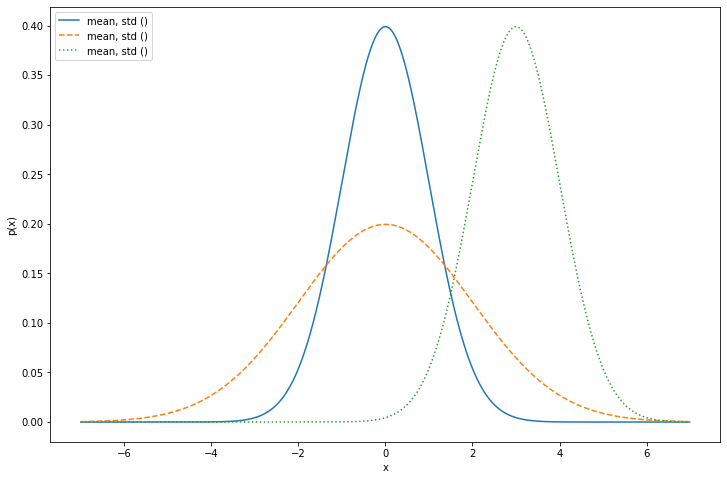

In [3]:
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, [normal(x, mu, sigma) for mu, sigma in params][0], '-', label=f"mean, std {()}".format(params[0]))
ax.plot(x, [normal(x, mu, sigma) for mu, sigma in params][1], '--', label=f"mean, std {()}".format(params[1]))
ax.plot(x, [normal(x, mu, sigma) for mu, sigma in params][2], ':', label=f"mean, std {()}".format(params[2]))
ax.set_xlabel("x")
ax.set_ylabel("p(x)")

ax.legend(loc="upper left")

## 线性回归的从零开始实现

In [4]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成数据集
在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。

In [5]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
features, features.shape, labels, labels.shape

(tensor([[-0.5666, -0.5757],
         [-0.2610, -0.0367],
         [ 0.0883, -0.5571],
         ...,
         [-0.1708, -0.4777],
         [-0.2941, -0.6687],
         [ 0.2810, -0.7380]]),
 torch.Size([1000, 2]),
 tensor([[ 5.0421e+00],
         [ 3.7947e+00],
         [ 6.2692e+00],
         [ 4.7770e+00],
         [ 3.7149e+00],
         [ 8.7252e+00],
         [ 1.1511e+01],
         [ 2.6656e+00],
         [ 8.8960e+00],
         [ 5.6325e+00],
         [-1.7540e+00],
         [ 6.3326e+00],
         [-8.9101e-01],
         [-3.8492e+00],
         [ 8.8158e-01],
         [-4.9782e+00],
         [ 6.4413e-01],
         [-1.0314e+00],
         [ 4.0671e+00],
         [ 7.2287e+00],
         [ 2.1090e+00],
         [ 4.4858e+00],
         [ 8.2492e+00],
         [ 4.1667e+00],
         [-1.5144e+00],
         [ 7.9381e+00],
         [ 4.0803e-03],
         [ 8.5249e+00],
         [-7.7132e-01],
         [ 3.1203e+00],
         [ 1.3870e+00],
         [ 5.6877e+00],
         [ 3.9659e

In [7]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.5666, -0.5757]) 
label: tensor([5.0421])


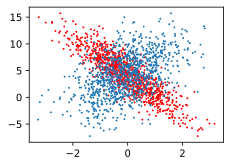

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].numpy(), labels.detach().numpy(), s=1, c="red") # 表示散点图点的大小；
d2l.plt.scatter(features[:, (0)].numpy(), labels.detach().numpy(), s=1) 

### 小批量随机读取数据集

采用**小批量随机梯度下降**，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能**打乱数据集中的样本并以小批量方式获取数据**。

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # random.shuffle()用于将一个列表中的元素打乱顺序，值得注意的是使用这个方法不会生成新的列表，只是将原列表的次序打乱。
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            # 切片，一次取一个batch_size的，不过最后的可能会超过，比如，取3个，但共有10个，3 3 3 3 最后一个3只有一个，若取3会报错；
            indices[i: min(i + batch_size, num_examples)]
        )
        # yield的函数是一个迭代器，函数返回某个值时，会停留在某个位置，返回函数值后，会在前面停留的位置继续执行，直到程序结束。
        # 返回一个随机批量的样本；
        yield features[batch_indices], labels[batch_indices]

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[ 2.1061, -1.2166],
        [-0.2690, -2.3107],
        [ 0.8938,  0.4124],
        [-0.2392, -0.8096],
        [ 1.3909,  0.2283],
        [ 0.5615,  0.3359],
        [-1.2585,  0.9040],
        [-0.2531,  1.0602],
        [ 1.7276, -1.2309],
        [-2.3122, -0.4268]]) 
 tensor([[12.5571],
        [11.5108],
        [ 4.5981],
        [ 6.4676],
        [ 6.2076],
        [ 4.1787],
        [-1.3983],
        [ 0.0769],
        [11.8481],
        [ 1.0304]])


### 初始化模型参数
开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数（初试的w，b）。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [11]:
# 需要对w，b计算梯度；
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型

In [12]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数
本节使用的平方差损失函数。

In [16]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法
sgd：随机梯度下降

In [14]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039987
epoch 2, loss 0.000160
epoch 3, loss 0.000048


In [18]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0009, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

### 生成数据集

In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [2]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [4]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

### 读取数据集

In [5]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    # *变量名 在python中做函数形参，可以表示一个可变长度的序列，不过是tuple类型，
    # 而**也可以做形参，而且是dict类型，他俩可以同时作为函数形参（也可以只有一个），不过若含有他俩的话得把*放在前面，而**在后。
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [6]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [7]:
# next() 返回迭代器的下一个项目
next(iter(data_iter))

[tensor([[ 0.3654,  2.4764],
         [-0.0348,  1.9518],
         [ 1.5435, -2.0761],
         [ 0.2649, -0.1447],
         [ 1.0702, -0.3284],
         [ 0.2435, -1.6016],
         [-1.2030, -0.0618],
         [-0.6278, -0.9502],
         [-1.3678,  0.4004],
         [ 0.6138, -0.8846]]),
 tensor([[-3.4872],
         [-2.4945],
         [14.3409],
         [ 5.2199],
         [ 7.4709],
         [10.1095],
         [ 2.0023],
         [ 6.1624],
         [ 0.1039],
         [ 8.4246]])]

### 定义模型

In [8]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1)) 
# 2 是输入维数， 第一个指定输入特征形状；
# 1 第二个指定输出特征形状,输出特征形状为单个标量,因此为1。

### 初始化模型参数

- 在使用net之前,我们需要初始化模型参数。
- 在线性回归模型中的权重和偏置。深度学习框架通常有预定义的方法来初始化参数。
- 我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样,偏置参数将初始化为零。

In [9]:
# net[0] 神经网络的第0层；
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [10]:
# 均方误差，mean squired loss
loss = nn.MSELoss()

### 定义优化算法

In [11]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练

In [12]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000176
epoch 2, loss 0.000101
epoch 3, loss 0.000101


In [13]:
w = net[0].weight.data 
print('w的估计误差:', true_w - w.reshape(true_w.shape)) 
b = net[0].bias.data 
print('b的估计误差:', true_b - b)

w的估计误差: tensor([ 0.0002, -0.0002])
b的估计误差: tensor([0.0005])
